In [27]:
import sys
sys.path.append('../')

matplotlib settings set


In [28]:
from scripts.utils import data_path, set_mpl, read_hamelin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


%matplotlib inline

set_mpl()

matplotlib settings set


In [29]:
energy, weather, metadata = read_hamelin()


    Loading Hamelin data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Houses number removed: 6, 17, 24, 25. 
    Houses with PV: ['13', '15', '26', '33'] 
    HOUSEHOLD and HEATPUMP energy consumption are separated. 
    Resolution: 60min 

    May-June 2019 data for home #34 excluded 
    Data before 2018-05-18 excluded (gaps)
    Data with zero difference between consecutive values dropped (malfunction)

    reutrns:
    df_energy: pd.DataFrame with energy consumption data
    df_weather: pd.DataFrame with weather data
    df_metadata: pd.DataFrame with metadata

    


## examples of bad or unclear data

Text(0.0, 1.0, 'Home 3')

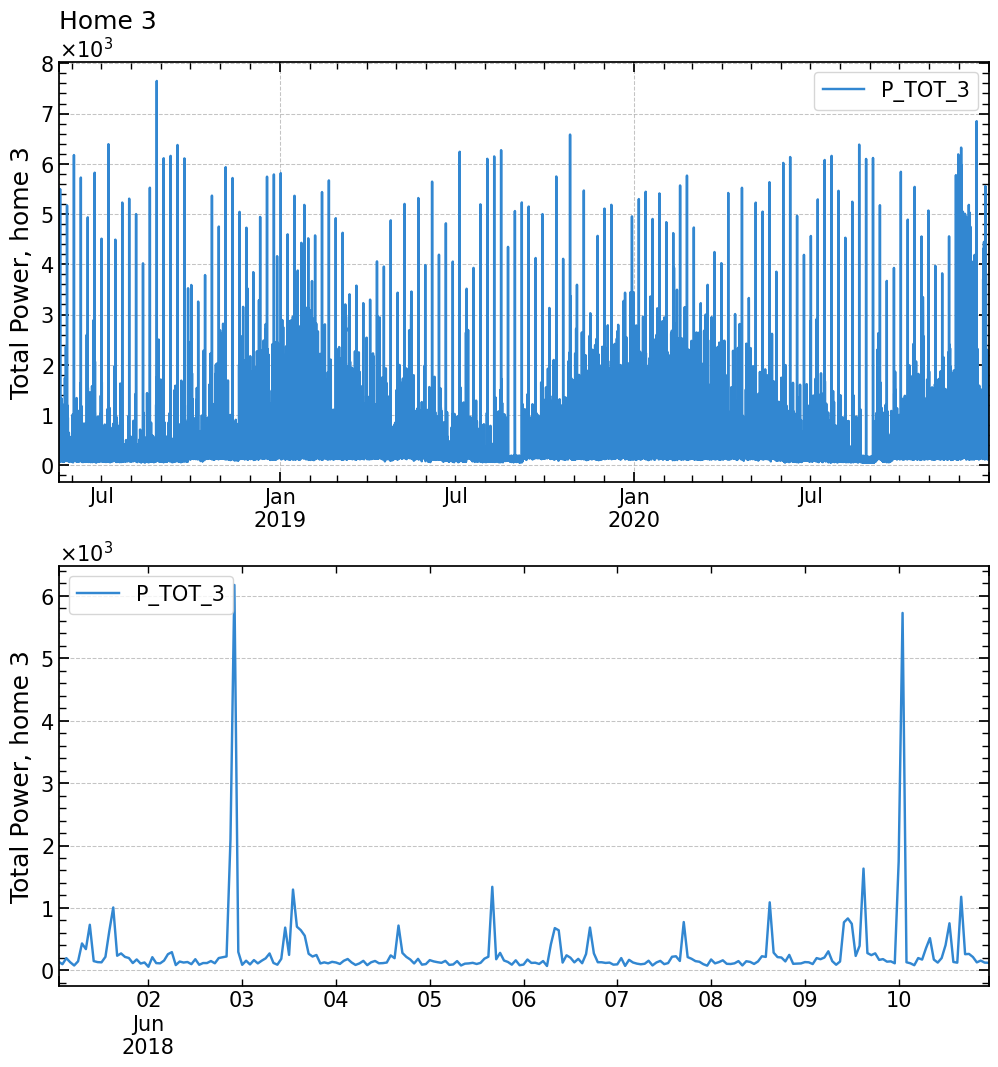

In [20]:
fig,  [ax1, ax2] =  plt.subplots(2, figsize = (12,12))

energy[['P_TOT_3']].plot(ax = ax1, ylabel = 'Total Power, home 3')
energy.query('index > "2018-06-01" & index < "2018-06-11"')[['P_TOT_3']].plot(ax = ax2, ylabel = 'Total Power, home 3')
ax1.set_title('Home 3')

Text(0.0, 1.0, 'Home 34')

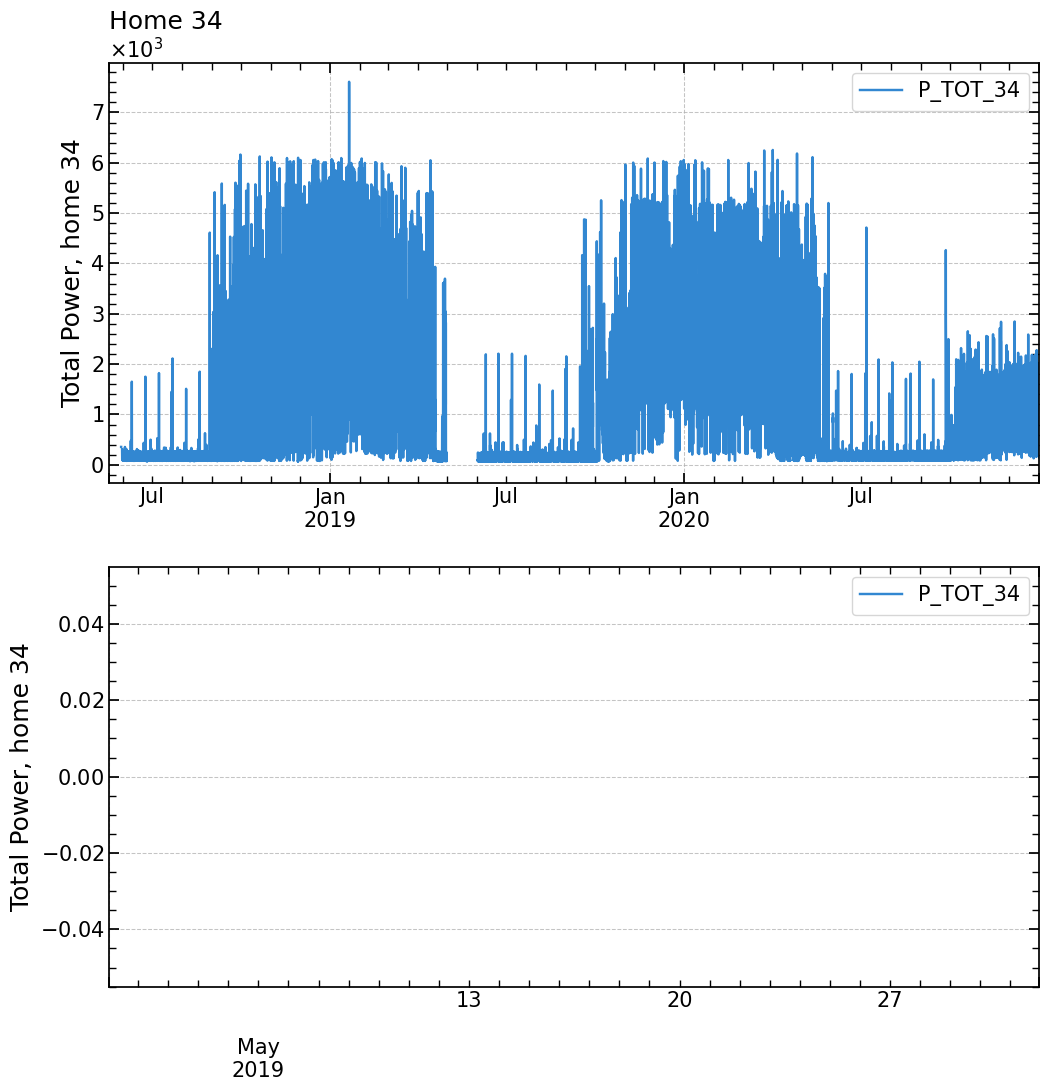

In [21]:

fig,  [ax1, ax2] =  plt.subplots(2, figsize = (12,12))

energy[['P_TOT_34']].plot(ax = ax1, ylabel = 'Total Power, home 34')
energy.query('index > "2019-05-01" & index < "2019-06-01"')[['P_TOT_34']].plot(ax = ax2, ylabel = 'Total Power, home 34')
ax1.set_title('Home 34')


# Preprocess data and time features

In [22]:
heat_cols = [col for col in energy.columns if 'P_HEAT' in col]
home_cols = [col for col in energy.columns if 'P_HOME' in col]
tot_cols = [col for col in energy.columns if 'P_TOT' in col]


#exclude May-June 2019 data for home # 34
energy.loc['2019-05-01':'2019-06-01', ['P_HOME_34',	'P_HEAT_34',	'P_TOT_34',]] = np.nan


energy['homes_num'] = energy[tot_cols].count(axis=1)

energy['P_HEAT_avg'] = energy[heat_cols].sum(axis=1)/energy['homes_num']
energy['P_HOME_avg'] = energy[home_cols].sum(axis=1)/energy['homes_num']
energy['P_TOT_avg'] = energy[tot_cols].sum(axis=1)/energy['homes_num']

#drop data before 2018-05-04
energy = energy.query('index > "2018-05-04"')


In [23]:

for df in [energy, weather]:
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    df['season'] = df['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
    df['workday'] = df['weekday'].apply(lambda x: 'workday' if x in [0, 1, 2, 3, 4] else 'weekend')


In [24]:

def find_bad_data(house_to_exclude='34'):

    fig,  [ax, ax2] =  plt.subplots(2, figsize = (12,10), sharex=True)

    subset = energy.copy()
    subset = subset.resample('1D').mean()

    home_avg = subset['P_HOME_avg']
    home_avg_w = (subset['P_HOME_avg']*subset['homes_num'] - subset[f'P_HOME_{house_to_exclude}'])/subset['homes_num']

    heat_avg = subset['P_HEAT_avg']
    heat_avg_w = (subset['P_HEAT_avg']*subset['homes_num'] - subset[f'P_HEAT_{house_to_exclude}'])/subset['homes_num']

    ax.plot(subset.index, home_avg, label=f'P_HOME_avg w/ {house_to_exclude}', alpha = 0.6, lw = 1)
    ax.plot(subset.index, home_avg_w, label='P_HOME_avg', alpha = 0.6, lw = 1)

    ax2.plot(subset.index,  heat_avg, label=f'P_HEAT_avg w/ {house_to_exclude}', alpha = 0.6, lw = 1)
    ax2.plot(subset.index, heat_avg_w, label='P_HEAT_avg', alpha = 0.6, lw = 1)

    ax.legend(loc = 'lower right')
    ax2.legend(loc = 'upper right')

    ax.set_xlabel('Time')
    ax.set_ylabel('Power [kW]')


    strange_idxs = abs(home_avg - home_avg_w) > 50
    strange_idxs = strange_idxs[strange_idxs].index

    for idx in strange_idxs:
        ax.axvline(idx, color = 'r', alpha = 0.1)

    strange_idxs = abs(heat_avg - heat_avg_w) > 200
    strange_idxs = strange_idxs[strange_idxs].index

    for idx in strange_idxs:
        ax2.axvline(idx, color = 'r', alpha = 0.1)

#find_bad_data('35') #bad at before turning off
#find_bad_data('20') #lower then average
#find_bad_data('19') #generally lower then average>
#find_bad_data('13') #1 week?
#find_bad_data('8') #1 week?
#find_bad_data('6') #1 day?
#find_bad_data('34')

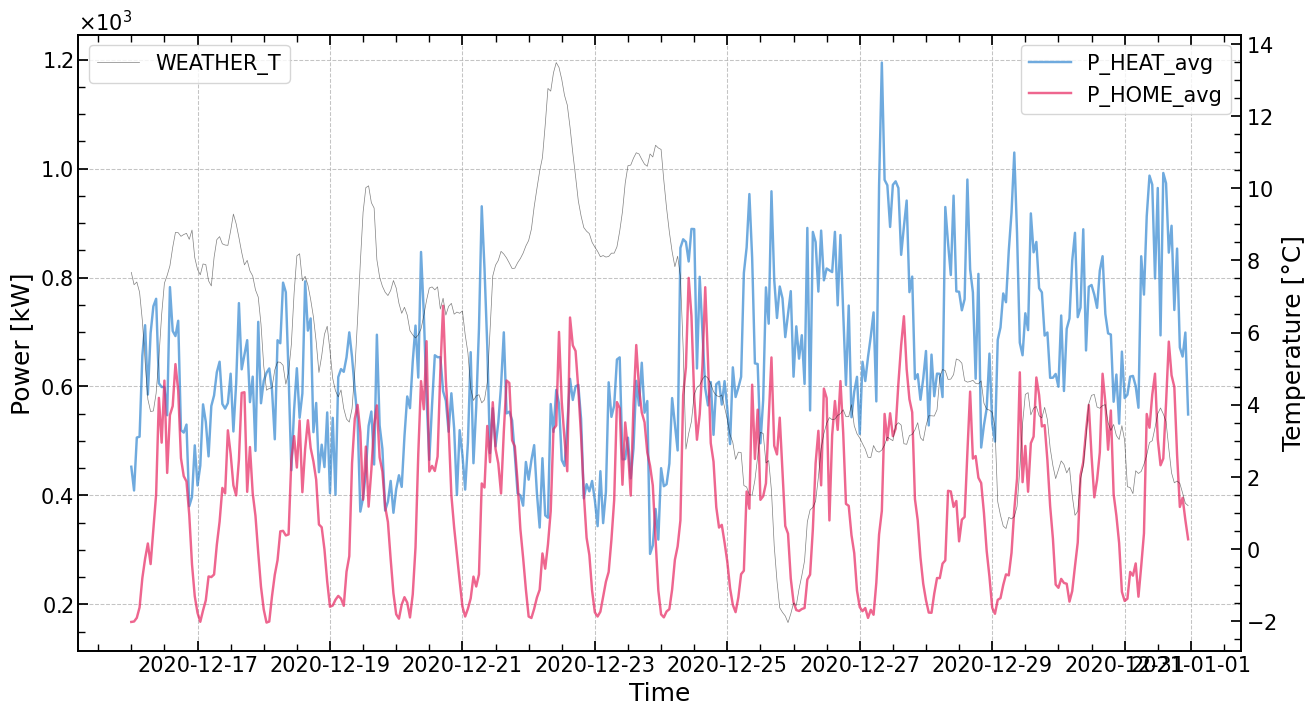

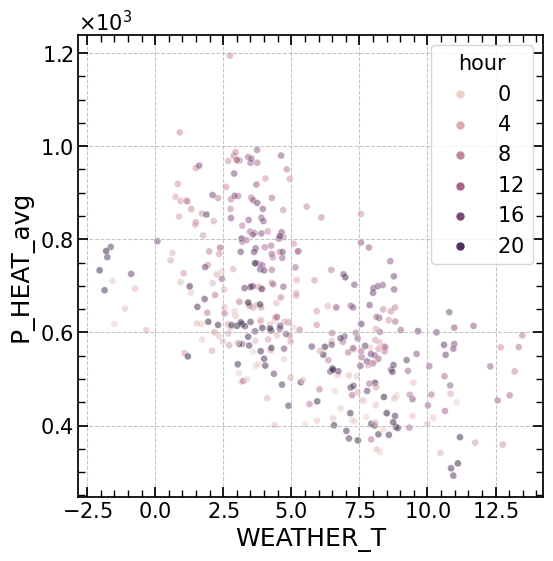

In [25]:
fig,  ax =  plt.subplots( figsize = (15,8))
ax2 = ax.twinx()
ax2.grid(False)
query = 'year == 2020 and month in [12] and doy>350'
subset = energy.query(query)
subset_weather = weather.query(query)
#ax.plot(subset.index, subset['P_substation'], label='P_substation')
ax.plot(subset.index, subset['P_HEAT_avg'], label='P_HEAT_avg', alpha = 0.7)
ax.plot(subset.index, subset['P_HOME_avg'], label='P_HOME_avg', alpha = 0.7)
ax2.plot(subset_weather.index, subset_weather['WEATHER_T'], label='WEATHER_T', color='k', lw = 0.5, alpha=0.5)


ax.legend(loc = 'upper right')
ax2.legend(loc = 'upper left')

ax.set_xlabel('Time')
ax.set_ylabel('Power [kW]')
ax2.set_ylabel('Temperature [°C]')


fig,  ax_t =  plt.subplots( figsize = (6,6))

sns.scatterplot(x=subset_weather['WEATHER_T'], y=subset['P_HEAT_avg'], hue = subset['hour'], alpha=0.5, ax = ax_t)

my_model_heat_temp = lambda T: 0.4e3 - 0.6e3/10*(T-10)

#xaxis = np.linspace(-2.5, 15, 20)
#ax_t.plot(xaxis, my_model_heat_temp(xaxis), color='r', lw = 2)
#ax.plot(subset.index, my_model_heat_temp(subset_weather['WEATHER_T']), label='my_model_heat_temp', color='m', lw = 2, alpha = 0.3)
